<h1>Tabla de contenidos<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción" data-toc-modified-id="Introducción-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción</a></span></li><li><span><a href="#Proyecto" data-toc-modified-id="Proyecto-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Proyecto</a></span><ul class="toc-item"><li><span><a href="#Librerias-utilizadas" data-toc-modified-id="Librerias-utilizadas-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Librerias utilizadas</a></span></li><li><span><a href="#Funciones-utilizadas-en-el-proyecto" data-toc-modified-id="Funciones-utilizadas-en-el-proyecto-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Funciones utilizadas en el proyecto</a></span></li><li><span><a href="#Preparación-de-los-datos." data-toc-modified-id="Preparación-de-los-datos.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Preparación de los datos.</a></span></li><li><span><a href="#Entrenamiento-y-pruebas-de-modelos" data-toc-modified-id="Entrenamiento-y-pruebas-de-modelos-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Entrenamiento y pruebas de modelos</a></span></li><li><span><a href="#Calculo-y-estadisticas-del-proyecto" data-toc-modified-id="Calculo-y-estadisticas-del-proyecto-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Calculo y estadisticas del proyecto</a></span></li></ul></li><li><span><a href="#Conclusión" data-toc-modified-id="Conclusión-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusión</a></span></li></ul></div>

### Introducción

Trabajamos en la compañía de extracción de petróleo OilyGiant. Tenemos que encontrar los mejores lugares donde abrir 200 pozos nuevos de petróleo. Para completar esta tarea, realizaremos los siguientes pasos:

- Leer los archivos con los parámetros recogidos de pozos petrolíferos en la región seleccionada: calidad de crudo y volumen de reservas.
- Crear un modelo para predecir el volumen de reservas en pozos nuevos.
- Elegir los pozos petrolíferos que tienen los valores estimados más altos.
- Elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados.


Tenemos los datos sobre muestras de crudo de tres regiones. Ya se conocen los parámetros de cada pozo petrolero de la región. Crea un modelo que ayude a elegir la región con el mayor margen de beneficio. Analizaremos los beneficios y riesgos potenciales utilizando la técnica bootstrapping.

Para este proyecto vamos a cumplir con ciertas condiciones y son las siguientes:

- Solo se debe usar la regresión lineal para el entrenamiento del modelo.
- Al explorar la región, se lleva a cabo un estudio de 500 puntos con la selección de los mejores 200 puntos para el cálculo del beneficio.
- El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares.
- Un barril de materias primas genera 4.5 USD de ingresos. El ingreso de una unidad de producto es de 4500 dólares (el volumen de reservas está expresado en miles de barriles).
- Después de la evaluación de riesgo, mantén solo las regiones con riesgo de pérdidas inferior al 2.5%. De las que se ajustan a los criterios, se debe seleccionar la región con el beneficio promedio más alto.

### Proyecto

#### Librerias utilizadas

- Comenzamos importando las librerias necesarias.

In [1]:
#Librerias iniciales
import pandas
import numpy
import matplotlib.pyplot as plt
#Librerias de Modelos y entrenamiento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#Librerias de metricas
from sklearn.metrics import mean_squared_error

#### Funciones utilizadas en el proyecto

Dejaremos esta seccion para declarar todas las funciones que utilizaremos en el proyecto.

- Funcion para normalizar datos

In [2]:
def normalizeData(data,columnsDrop,target):
    # Estandarizamos los datos con el StandardScaler
    scaler = StandardScaler()
    
    # Realizamos el metodo solo en las columnas que queremos, asi que eliminamos el target del DataFrame
    data_transformed=data.drop(target, axis=1)
    data_transformed=pandas.DataFrame(scaler.fit_transform(data_transformed), columns=data_transformed.columns)
    #data_transformed.info()
    
    # Eliminamos las columnas del DataFrame original para ser remplazadas por los datos estandarrizados.
    data = data.drop(columnsDrop, axis=1)
    data = pandas.concat([data_transformed,data],axis=1)
    #data.info()
    
    return data

- Funcion para realizar los conjuntos de entrenamiento y validacion

In [3]:
def trainSets(dataFrame,target,testSize,randomState):
        
    # Obtendemos el conjunto de entrenamiento y validacion.
    train,valid=train_test_split(dataFrame,test_size=testSize,random_state=randomState)

    #Entrenamiento
    features_train=train.drop([target],axis=1)
    target_train=train[target]
    #Validacion
    features_valid=valid.drop([target],axis=1)
    target_valid= valid[target]
    
    return features_train,target_train,features_valid,target_valid

- Funcion para entrenar modelos

In [4]:
def trainModel(features_train,target_train,features_valid,target_valid,randomState):
    # Comenzamos con el modelo
    model= LinearRegression()
    model.fit(features_train,target_train)
    predictions_valid=model.predict(features_valid)# Obtenemos las predicciones del modelo en el conjunto de validación.
    rmse=mean_squared_error(target_valid,predictions_valid)**0.5
    print('El RMSE del modelo es:',rmse)
    print(features_valid)
    return model,predictions_valid 

- Función para el Bootstrapping para el intervalo de confianza

In [5]:
def confidence_interval(data,randomState):
    state = np.random.RandomState(12345)

    # Guarda los valores del cuantil del 99 % en la variable de valores
    values = []
    for i in range(1000):
        subsample = data.sample(replace=True, random_state=state)
        values.append(subsample.quantile(0.99))

    values = pd.Series(values)

    lower = values.quantile(0.05)
    upper = values.quantile(0.95)

    print(lower)
    print(upper)

- Función para el Bootstrapping para el análisis de pruebas A/B

In [6]:
def test_analysis(data_a,data_b,randomState):
    # diferencia real entre las medias de los grupos
    AB_difference = data_b.mean() - data_a.mean()
    print("Diferencia entre los importes promedios de compra:", AB_difference)

    alpha = 0.05
    state = np.random.RandomState(randomState)
    bootstrap_samples = 1000
    count = 0
    for i in range(bootstrap_samples):
        # concatena las muestras
        united_samples =  pd.concat([data_a, data_b])
        # crea una submuestra
        subsample = united_samples.sample(n=500, replace=True, random_state=state)
        # divide la submuestra por la mitad
        subsample_A = subsample[:len(data_a)]
        subsample_B = subsample[len(data_a):]
        # encuentra la diferencia entre las medias
        bootstrap_difference = subsample_B.mean()-subsample_A.mean()
        # si la diferencia no es menor que la diferencia real, añade "1" al contador
        if bootstrap_difference >= AB_difference:
            count += 1
    # el valor p es igual al porcentaje de valores excedentes
    pvalue = 1. * count / bootstrap_samples
    print('p-value =', pvalue)

    if pvalue < alpha:
        print("La hipótesis nula se rechaza, a saber, es probable que el importe promedio de las compras aumente")
    else:
        print("La hipótesis nula no se rechaza, a saber, es poco probable que el importe medio de las compras aumente")

- Función para el calcular ganancias.

In [7]:
def revenue(df,income,presupuesto):
    top_200_pozos=df.sort_values(by="predicted_value", ascending=False)['product'].head(200) 
    volumen_total = top_200_pozos.sum()
    benefits= ((volumen_total*income)-presupuesto) 
    return benefits


- Función para el Bootstrapping para modelos

In [22]:
def bootstrapping_for_model(df,n_muestras,income,presupuesto,randomState):
    
    state = numpy.random.RandomState(randomState)

    benefit_muestra=[]
    for i in range(n_muestras):
        pozos = df.sample(n=500,replace=True, random_state=state) 
        benefit_muestra.append(revenue(pozos,income,presupuesto))
    
    benefit_muestra = pandas.Series(benefit_muestra)

    lower = benefit_muestra.quantile(0.05)
    upper = benefit_muestra.quantile(0.95)
    mean = benefit_muestra.mean()
    
    print("Ingresos promedio:", mean)
    print("Cuantil del 5 %:", lower)
    print("Cuantil del 95%:",upper)
    
    return benefit_muestra

#### Preparación de los datos.

- Leemos los datasets.

In [9]:
df_geo_0=pandas.read_csv('/datasets/geo_data_0.csv')
df_geo_1=pandas.read_csv('/datasets/geo_data_1.csv')
df_geo_2=pandas.read_csv('/datasets/geo_data_2.csv')

- Revisamos los datos de cada Datasets, como tambien si es que hay filas duplicadas o datos ausentes.

In [10]:
print('Revisemos el dataset geo_data_0.csv')
print()
# Información del dataset.
df_geo_0.info()
print()
# Descripcion del dataset.
print(df_geo_0.describe())
print()
# Revisamos los datos duplicados
print('Comprobamos los datos duplicados en el dataset.')
print('El dataset tiene',df_geo_0.duplicated().sum(),'duplicados.')
print()
# Revisamos los datos eliminados
print('Comprobamos si hay datos nulos.')
print(df_geo_0.isnull().sum())
# Revisamos las 10 primeras filas del DataFrame
print()
df_geo_0.head(10)

Revisemos el dataset geo_data_0.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [11]:
print('Revisemos el dataset geo_data_1.csv')
print()
# Información del dataset.
df_geo_1.info()
print()
# Descripcion del dataset.
print(df_geo_1.describe())
print()
# Revisamos los datos duplicados
print('Comprobamos los datos duplicados en el dataset.')
print('El dataset tiene',df_geo_1.duplicated().sum(),'duplicados.')
print()
# Revisamos los datos eliminados
print('Comprobamos si hay datos nulos.')
print(df_geo_1.isnull().sum())
# Revisamos las 10 primeras filas del DataFrame
print()
df_geo_1.head(10)

Revisemos el dataset geo_data_1.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [12]:
print('Revisemos el dataset geo_data_2.csv')
print()
# Información del dataset.
df_geo_2.info()
print()
# Descripcion del dataset.
print(df_geo_2.describe())
print()
# Revisamos los datos duplicados
print('Comprobamos los datos duplicados en el dataset.')
print('El dataset tiene',df_geo_2.duplicated().sum(),'duplicados.')
print()
# Revisamos los datos eliminados
print('Comprobamos si hay datos nulos.')
print(df_geo_2.isnull().sum())
# Revisamos las 10 primeras filas del DataFrame
print()
df_geo_2.head(10)

Revisemos el dataset geo_data_2.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


- Observamos que la columna 'id' en los DatasFrame son 'String' y que no aportan nada para el entrenamiento de nuestro modelo por lo que no vale la pena realizarle un proceso de encode, por lo que la vamos a borrar.

In [13]:
df_geo_0= df_geo_0.drop('id',axis=1)
df_geo_1= df_geo_1.drop('id',axis=1)
df_geo_2= df_geo_2.drop('id',axis=1)

# Revisamos que efectivamente se hayan borrado las columnas.
df_geo_0.info()
df_geo_1.info()
df_geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1 

Histogramas para la columna f 0
Geo Data 0


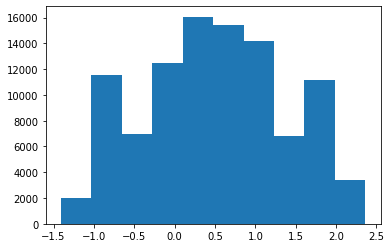

Geo Data 1


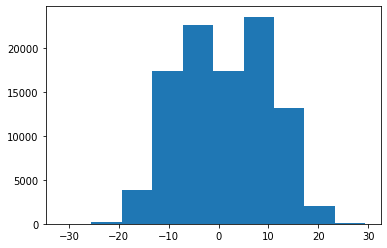

Geo Data 2


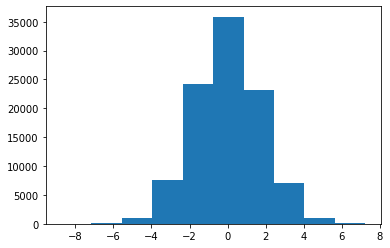

Histogramas para la columna f 1
Geo Data 0


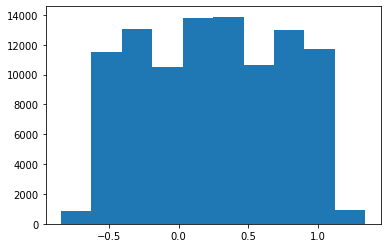

Geo Data 1


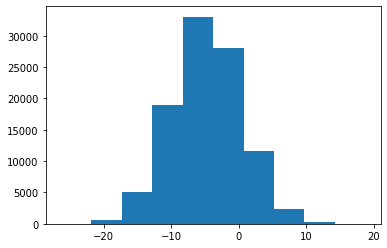

Geo Data 2


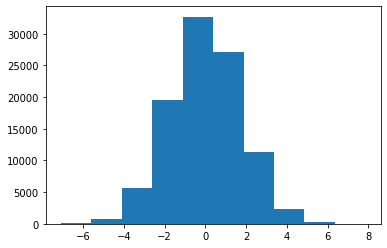

Histogramas para la columna f 2
Geo Data 0


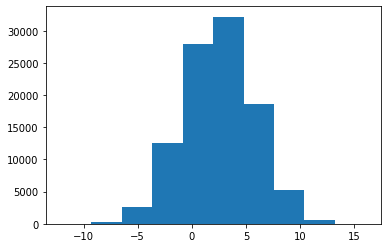

Geo Data 1


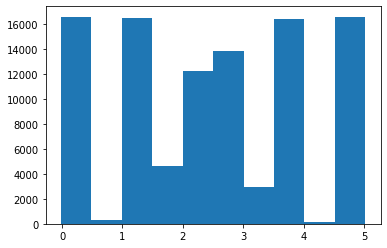

Geo Data 2


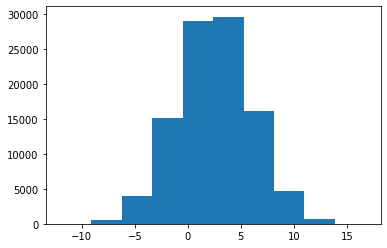

In [14]:
for i in range(3):
    print('Histogramas para la columna f',i)
    print('Geo Data 0')
    plt.hist(df_geo_0.iloc[:,i])
    plt.show()
    print('Geo Data 1')
    plt.hist(df_geo_1.iloc[:,i])
    plt.show()
    print('Geo Data 2')
    plt.hist(df_geo_2.iloc[:,i])
    plt.show()
    

In [15]:
df_geo_0=normalizeData(df_geo_0,['f0','f1','f2'],'product')
df_geo_1=normalizeData(df_geo_1,['f0','f1','f2'],'product')
df_geo_2=normalizeData(df_geo_2,['f0','f1','f2'],'product')

#### Entrenamiento y pruebas de modelos

Como vamos a realizar los conjuntos de entrenamiento, validacion y testeo correspondiente al número de DataFrame que tenemos, el proceso de entrenamiento para cada modelo sera a traves de funciones que utilizaremos en cada modelo.

- Creamos una función para crear los conjuntos de entrenamiento y validacion con proporcion 75:25 para posteriormente entrenar el modelo y asi retornar un modelo entrenado con la función.

In [16]:
# Obtenemos los conjuntos de entrenamiento y validacion para la primera región
features_train_0,target_train_0,features_valid_0,target_valid_0= trainSets(df_geo_0,'product',0.25,54321)
# Obtenemos los conjuntos de entrenamiento y validacion para la segunda región
features_train_1,target_train_1,features_valid_1,target_valid_1= trainSets(df_geo_1,'product',0.25,54321)
# Obtenemos los conjuntos de entrenamiento y validacion para la tercera región
features_train_2,target_train_2,features_valid_2,target_valid_2= trainSets(df_geo_2,'product',0.25,54231)

- Ahora creamos los diferentes conjuntos de modelo para cada region correspondiente.

In [17]:
print('Modelo 0:')
model_0,predictions_0=trainModel(features_train_0,target_train_0,features_valid_0,target_valid_0,12345)
print()
print('Modelo 1:')
model_1,predictions_1=trainModel(features_train_1,target_train_1,features_valid_1,target_valid_1,12345)
print()
print('Modelo 2:')
model_2,predictions_2=trainModel(features_train_2,target_train_2,features_valid_2,target_valid_2,12345)

Modelo 0:
El RMSE del modelo es: 37.68341093860808
             f0        f1        f2
47590  1.163499 -0.868710  0.357863
39469  1.306170 -1.524645  0.705086
88291 -0.503067  0.493214 -0.148966
46565  0.055040 -1.144698 -0.221402
55316 -0.656839  1.335292  0.126680
...         ...       ...       ...
27645  1.708992  0.174967  1.144315
57064 -0.458142 -0.496682  0.591779
73541  0.507760  0.389652  0.281978
10466 -1.435712  0.831824  2.302754
14296  0.576066 -0.098650  0.793750

[25000 rows x 3 columns]

Modelo 1:
El RMSE del modelo es: 0.892281970848147
             f0        f1        f2
47590  1.229753  2.586988 -0.876886
39469 -0.642109 -0.249918 -1.464878
88291  1.935910  0.552506  0.878490
46565 -0.827784  0.444880 -0.291587
55316 -0.944756  2.042686  0.884200
...         ...       ...       ...
27645 -0.602915 -1.151283 -1.468166
57064  0.947552  0.853730 -1.470077
73541 -0.981110 -0.358875  0.298147
10466 -0.954442 -0.158365 -1.463627
14296 -0.545814 -1.378312 -0.876616

[25000

- Las predicciones obtenidas la concatenaremos a sus dataframe por region correspondiente.

In [18]:
df_geo_0['predicted_value']=model_0.predict(df_geo_0.iloc[:,:3])
df_geo_0.info()
df_geo_1['predicted_value']=model_1.predict(df_geo_1.iloc[:,:3])
df_geo_1.info()
df_geo_2['predicted_value']=model_2.predict(df_geo_2.iloc[:,:3])
df_geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   f0               100000 non-null  float64
 1   f1               100000 non-null  float64
 2   f2               100000 non-null  float64
 3   product          100000 non-null  float64
 4   predicted_value  100000 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   f0               100000 non-null  float64
 1   f1               100000 non-null  float64
 2   f2               100000 non-null  float64
 3   product          100000 non-null  float64
 4   predicted_value  100000 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeI

#### Calculo y estadisticas del proyecto

- Recordemos que tenemos una inversion(presupuesto) de 100 millones por los 200 pozos de petroleo, y en media un pozo debe producir al menos 500.000 dolares (income=ingreso)

In [19]:
revenue_0=revenue(df_geo_0,50000,100000000)
revenue_1=revenue(df_geo_1,50000,100000000)
revenue_2=revenue(df_geo_2,50000,100000000)

In [20]:
print('Las ganacias para la primera region(geo_0)es:',revenue_0)
print('Las ganacias para la primera region(geo_1)es:',revenue_1)
print('Las ganacias para la primera region(geo_2)es:',revenue_2)

Las ganacias para la primera region(geo_0)es: 1399148053.3086357
Las ganacias para la primera region(geo_1)es: 1279454077.409057
Las ganacias para la primera region(geo_2)es: 1302049306.3634608


- Ahora haremos la distibicion de los beneficios con bootstraping aplicando 1000 muestras

In [24]:
print('Distribucion de los beneficios para geo_0')
boot_revenue_0=bootstrapping_for_model(df_geo_0,1000,500000,100000000,12345)
print('')
print('Distribucion de los beneficios para geo_1')
boot_revenue_1=bootstrapping_for_model(df_geo_1,1000,500000,100000000,12345)
print('')
print('Distribucion de los beneficios para geo_2')
boot_revenue_2=bootstrapping_for_model(df_geo_2,1000,500000,100000000,12345)

Distribucion de los beneficios para geo_0
Ingresos promedio: 11481846916.36908
Cuantil del 5 %: 10999446334.845694
Cuantil del 95%: 11991024765.780512

Distribucion de los beneficios para geo_1
Ingresos promedio: 11509694368.692152
Cuantil del 5 %: 11151842694.84712
Cuantil del 95%: 11862372122.193941

Distribucion de los beneficios para geo_2
Ingresos promedio: 11426132976.825489
Cuantil del 5 %: 10914031716.809166
Cuantil del 95%: 11912643970.363644


### Conclusión

Como podemos ver los resultados donde obtenemos una mayor cantidad de ingresos promedios son en la loxalizacion de geo_1 por el modelo de Bootstraping pero a la hora que realizamos el calculo de ganancias en los mejores 200 pozos observamos que esta region es la peor comparada con las otras 2, cuando realizamos el calculo de ganancias generales la mejor region es la 0 ya que supera por creces a nivel monetario a las otras 2 regiones. 